<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Exams/finals/NGupta_question1_unigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk
from nltk.util import ngrams

# Get the Data

In [2]:
import os.path

filename = "Sentiment.csv"
if os.path.isfile(filename):
  print("File already exists. Will reuse the same ...")
else:
  use_github_data = False
  if use_github_data:
    print("Loading fie from Github ...")
    filename = "https://github.com/ngupta23/ds7337_nlp/blob/master/Exams/finals/Sentiment.csv"
  else:
    print("Please upload your file to Colab ...")
    from google.colab import files
    uploaded = files.upload()

File already exists. Will reuse the same ...


# Data Preparation

In [3]:
data = pd.read_csv(filename) #, encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [4]:
data = data[['text', 'sentiment']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       13871 non-null  object
 1   sentiment  13871 non-null  object
dtypes: object(2)
memory usage: 216.9+ KB


In [5]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


# Find Maximum Sequence Length

In [6]:
data['len'] = data['text'].str.len()
data.head()

,text,sentiment,len
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral,106
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive,140
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral,84
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive,140
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive,140


In [7]:
print('Maximum review length: {}'.format(data['len'].max()))
print('Minimum review length: {}'.format(data['len'].min()))


Maximum review length: 153
Minimum review length: 19


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f374c38c908>]],
      dtype=object)

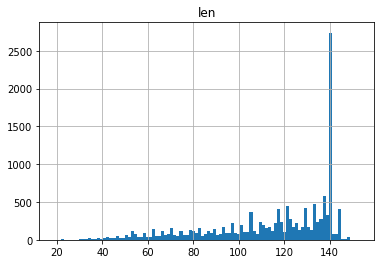

In [8]:
data.hist(bins=100)

In [9]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
import numpy as np
time_steps = int(np.quantile(data['len'],0.975))
time_steps

144

# Prepare Label

In [10]:
data['sentiment'].value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [11]:
data.loc[data['sentiment'] == 'Negative', 'sentiment'] = 0
data.loc[data['sentiment'] == 'Neutral', 'sentiment'] = 1
data.loc[data['sentiment'] == 'Positive', 'sentiment'] = 2

In [12]:
data['sentiment'].value_counts()

0    8493
1    3142
2    2236
Name: sentiment, dtype: int64

# Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text'].values.astype('U'),
    data['sentiment'].values.astype('int32'),
    test_size=0.20,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_test)}, y_test: {len(y_test)}")

Number of samples: X_train: 11096, y_train: 11096
Number of samples: X_test: 2775, y_test: 2775


In [14]:
# Checking split --> both test and train contain roughly the same number of positive (and negative) sentiment reviews
print(sum(y_train == 0)/len(y_train), sum(y_test == 0)/len(y_test))
print(sum(y_train == 1)/len(y_train), sum(y_test == 1)/len(y_test))
print(sum(y_train == 2)/len(y_train), sum(y_test == 2)/len(y_test))

0.6102198990627253 0.6205405405405405
0.22801009372746936 0.22054054054054054
0.16177000720980533 0.1589189189189189


# Create Vocabulary

In [15]:
# Unigram
print(list(data.iloc[0]['text']))

['R', 'T', ' ', '@', 'N', 'a', 'n', 'c', 'y', 'L', 'e', 'e', 'G', 'r', 'a', 'h', 'n', ':', ' ', 'H', 'o', 'w', ' ', 'd', 'i', 'd', ' ', 'e', 'v', 'e', 'r', 'y', 'o', 'n', 'e', ' ', 'f', 'e', 'e', 'l', ' ', 'a', 'b', 'o', 'u', 't', ' ', 't', 'h', 'e', ' ', 'C', 'l', 'i', 'm', 'a', 't', 'e', ' ', 'C', 'h', 'a', 'n', 'g', 'e', ' ', 'q', 'u', 'e', 's', 't', 'i', 'o', 'n', ' ', 'l', 'a', 's', 't', ' ', 'n', 'i', 'g', 'h', 't', '?', ' ', 'E', 'x', 'a', 'c', 't', 'l', 'y', '.', ' ', '#', 'G', 'O', 'P', 'D', 'e', 'b', 'a', 't', 'e']


In [16]:
corpus = []
for _, text_row in enumerate(data['text']):
  corpus = corpus + list(text_row)

In [17]:
print(corpus[:300])

['R', 'T', ' ', '@', 'N', 'a', 'n', 'c', 'y', 'L', 'e', 'e', 'G', 'r', 'a', 'h', 'n', ':', ' ', 'H', 'o', 'w', ' ', 'd', 'i', 'd', ' ', 'e', 'v', 'e', 'r', 'y', 'o', 'n', 'e', ' ', 'f', 'e', 'e', 'l', ' ', 'a', 'b', 'o', 'u', 't', ' ', 't', 'h', 'e', ' ', 'C', 'l', 'i', 'm', 'a', 't', 'e', ' ', 'C', 'h', 'a', 'n', 'g', 'e', ' ', 'q', 'u', 'e', 's', 't', 'i', 'o', 'n', ' ', 'l', 'a', 's', 't', ' ', 'n', 'i', 'g', 'h', 't', '?', ' ', 'E', 'x', 'a', 'c', 't', 'l', 'y', '.', ' ', '#', 'G', 'O', 'P', 'D', 'e', 'b', 'a', 't', 'e', 'R', 'T', ' ', '@', 'S', 'c', 'o', 't', 't', 'W', 'a', 'l', 'k', 'e', 'r', ':', ' ', 'D', 'i', 'd', 'n', "'", 't', ' ', 'c', 'a', 't', 'c', 'h', ' ', 't', 'h', 'e', ' ', 'f', 'u', 'l', 'l', ' ', '#', 'G', 'O', 'P', 'd', 'e', 'b', 'a', 't', 'e', ' ', 'l', 'a', 's', 't', ' ', 'n', 'i', 'g', 'h', 't', '.', ' ', 'H', 'e', 'r', 'e', ' ', 'a', 'r', 'e', ' ', 's', 'o', 'm', 'e', ' ', 'o', 'f', ' ', 'S', 'c', 'o', 't', 't', "'", 's', ' ', 'b', 'e', 's', 't', ' ', 'l', 'i',

In [18]:
fdist = nltk.FreqDist(corpus)
print(fdist.most_common()) # [:20])
# We can use the count to filter out less common words (noise), but this has not been done here.
vocab = [char for char, count in fdist.most_common() if count >= 1] 
print(vocab) #[:20])

[(' ', 223579), ('e', 140036), ('t', 106711), ('a', 93539), ('o', 76702), ('i', 66303), ('n', 65948), ('s', 64543), ('r', 61717), ('h', 46854), ('l', 44837), ('d', 35894), ('u', 32895), ('b', 30766), ('c', 28161), ('m', 26989), ('p', 25019), ('#', 21730), ('g', 21283), ('y', 20289), ('G', 20251), ('D', 19126), ('O', 18879), ('P', 18623), ('w', 17702), ('.', 17621), ('T', 17575), ('f', 16756), ('R', 14460), ('@', 14178), (':', 13538), ('k', 12210), ('/', 11598), ('v', 8618), ('S', 7626), ('I', 6954), ('W', 6618), ('C', 6510), ("'", 5657), (',', 5164), ('A', 5003), ('F', 5001), ('B', 4805), ('N', 4682), ('M', 4115), ('x', 3912), ('H', 3712), ('"', 3544), ('L', 3354), ('E', 3069), ('?', 2892), ('…', 2868), ('\n', 2775), ('j', 2483), ('J', 2412), ('1', 2333), ('z', 2331), ('!', 2287), ('K', 2220), ('U', 1987), ('0', 1899), ('2', 1861), ('🇺', 1830), ('🇸', 1830), ('-', 1757), ('Y', 1722), ('q', 1592), ('6', 1369), (';', 1241), ('V', 1228), ('&', 1144), ('3', 1090), ('4', 972), ('5', 962), ('

In [19]:
print(len(vocab))

243


In [20]:
word_index = {}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
for index, word in enumerate(vocab):
  word_index[word] = index+3

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
[(i, reverse_word_index.get(i)) for i in np.arange(10)]

[(0, '<PAD>'),
 (1, '<START>'),
 (2, '<UNK>'),
 (3, ' '),
 (4, 'e'),
 (5, 't'),
 (6, 'a'),
 (7, 'o'),
 (8, 'i'),
 (9, 'n')]

In [22]:
vocabulary_size = len(word_index.keys())
vocabulary_size

246

# Encoding and Decoding

In [23]:
def encode_review(plain_text: str) -> List[int]:
  return [word_index[token] if token in word_index.keys() else word_index["<UNK>"] for token in list(plain_text)]

def decode_review(encoded_text):
  return ' '.join([reverse_word_index.get(i, '?') for i in encoded_text])

In [24]:
def encode_decode_check(original_review):
  print("\n")
  print(f"Original Review: {original_review}")
  encoded_review = encode_review(original_review)
  print(f"Encoded Review: {encoded_review}")
  decoded_review = decode_review(encoded_review)
  print(f"Decoded Review: {decoded_review}")
  # same = decoded_review == original_review
  # print(f"Decoded = Original: {same}")

In [25]:
random_train_reviews = X_train[np.random.choice(len(X_train), 5)]
random_train_reviews

for review in random_train_reviews:
  encode_decode_check(review)



Original Review: FloridaMEP: RT IMPOmag: #Manufacturing Group Knocks Trump Ahead Of #GOPDebate http://t.co/f3Kh6lVjjn #DonaldTrump http://t.co/XY3tBz78dd
Encoded Review: [44, 13, 7, 11, 8, 14, 6, 47, 52, 26, 33, 3, 31, 29, 3, 38, 47, 26, 25, 18, 6, 21, 33, 3, 20, 47, 6, 9, 15, 30, 6, 17, 5, 15, 11, 8, 9, 21, 3, 23, 11, 7, 15, 19, 3, 61, 9, 7, 17, 34, 10, 3, 29, 11, 15, 18, 19, 3, 43, 12, 4, 6, 14, 3, 25, 30, 3, 20, 23, 25, 26, 24, 4, 16, 6, 5, 4, 3, 12, 5, 5, 19, 33, 35, 35, 5, 28, 17, 7, 35, 30, 74, 61, 12, 70, 13, 72, 56, 56, 9, 3, 20, 24, 7, 9, 6, 13, 14, 29, 11, 15, 18, 19, 3, 12, 5, 5, 19, 33, 35, 35, 5, 28, 17, 7, 35, 77, 68, 74, 5, 45, 59, 79, 80, 14, 14]
Decoded Review: F l o r i d a M E P :   R T   I M P O m a g :   # M a n u f a c t u r i n g   G r o u p   K n o c k s   T r u m p   A h e a d   O f   # G O P D e b a t e   h t t p : / / t . c o / f 3 K h 6 l V j j n   # D o n a l d T r u m p   h t t p : / / t . c o / X Y 3 t B z 7 8 d d


Original Review: RT @RWSurferGirl: I'

In [26]:
random_test_reviews = X_test[np.random.choice(len(X_test), 5)]
random_test_reviews

for review in random_test_reviews:
  encode_decode_check(review)



Original Review: RT @RWSurferGirl: Thanks Fox News, you're raising @realDonaldTrump 's ratings. 🇺🇸 #GOPDebate  #GOPDebates
Encoded Review: [31, 29, 3, 32, 31, 39, 37, 15, 11, 30, 4, 11, 23, 8, 11, 13, 33, 3, 29, 12, 6, 9, 34, 10, 3, 44, 7, 48, 3, 46, 4, 27, 10, 42, 3, 22, 7, 15, 41, 11, 4, 3, 11, 6, 8, 10, 8, 9, 21, 3, 32, 11, 4, 6, 13, 24, 7, 9, 6, 13, 14, 29, 11, 15, 18, 19, 3, 41, 10, 3, 11, 6, 5, 8, 9, 21, 10, 28, 3, 65, 66, 3, 20, 23, 25, 26, 24, 4, 16, 6, 5, 4, 3, 3, 20, 23, 25, 26, 24, 4, 16, 6, 5, 4, 10]
Decoded Review: R T   @ R W S u r f e r G i r l :   T h a n k s   F o x   N e w s ,   y o u ' r e   r a i s i n g   @ r e a l D o n a l d T r u m p   ' s   r a t i n g s .   🇺 🇸   # G O P D e b a t e     # G O P D e b a t e s


Original Review: RT @SupermanHotMale: Donald Trump: Money talks and bullshit walks, he wants to bribe every elected official in America... FU Trump #GopDeba…
Encoded Review: [31, 29, 3, 32, 37, 15, 19, 4, 11, 18, 6, 9, 49, 7, 5, 47, 6, 13, 4, 33, 3, 24

In [27]:
X_train_encoded = [encode_review(review) for review in X_train]
X_test_encoded = [encode_review(review) for review in X_test]

# Zero Padding

In [28]:
from tensorflow.keras.preprocessing import sequence

X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)

In [29]:
X_train_encoded[0:2]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, 31, 29,  3, 32, 31, 39, 37, 15, 11,
        30,  4, 11, 23,  8, 11, 13, 33,  3, 39,  4,  3,  5, 12,  4,  3,
        43, 18,  4, 11,  8, 17,  6,  9,  3, 19,  4,  7, 19, 13,  4,  3,
        19,  8, 17, 34,  3,  5, 12,  4,  3,  9,  4, 48,  5,  3, 26, 11,
         4, 10,  8, 14,  4,  9,  5,  3,  7, 30,  3, 62,  9,  8,  5,  4,
        14,  3, 37,  5,  6,  5,  4, 10,  3,  9,  7,  5,  3, 44, 25, 77,
         3, 46,  4, 27, 10,  3, 65, 66,  3, 20, 23, 25, 26, 24,  4, 16,
         6,  5,  4,  3,  3, 20, 23, 25, 26, 24,  4, 16,  6,  5,  4, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 31, 29,  3, 32, 61,  4, 36,
        77, 38,  9, 14, 22, 33,  3, 38,  3, 10,  4, 11,  8,  7, 15, 10,
        13, 22,  3, 27,  8, 10, 12,  3, 32, 57,  6, 18,  4, 10,

In [30]:
X_test_encoded[0:2]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 29,  7,  3, 18,  4, 42,  3,  5, 12,  4,  3, 11,
         4,  6, 13,  3, 27,  8,  9,  9,  4, 11,  3,  7, 30,  3, 13,  6,
        10,  5,  3,  9,  8, 21, 12,  5,  3, 20, 23, 25, 26, 24,  4, 16,
         6,  5,  4,  3, 27,  6, 10,  3, 32, 18,  4, 21, 22,  9, 34,  4,
        13, 13, 22, 28,  3, 20, 47,  4, 21, 22,  9, 61,  4, 13, 13, 22],
       [ 0,  0,  0,  0, 31, 29,  3, 32, 24,  6,  9, 37, 17,  6, 36,  8,
         9,  7, 33,  3, 28, 32, 18,  4, 21, 22,  9, 34,  4, 13, 13, 22,
        42, 55, 37,  7, 18,  4,  3, 11,  4, 10, 15, 13,  5, 10,  3,  7,
         9,  3, 12,  7, 27,  3, 17,  6,  9, 14,  8, 14,  6,  5,  4, 10,
         3, 14,  8, 14,  3,  6,  5,  3, 20, 23, 25, 26, 24,  4,

# Model Training

In [31]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM as LSTM
from tensorflow.keras.layers import GRU as GRU

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 'patience' epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=3)

In [34]:
# import other libs as needed for building model
from tensorflow.keras.callbacks import ModelCheckpoint

# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [35]:
def create_model(
    vocabulary_size: int,
    time_steps: int,
    embedding_size: int,
    num_classes: int,
    type: str = 'lstm',
    num_neuron: int=100,
    dropout: float=0,
    recurrent_dropout: float=0
    ) -> tf.keras.layers.Layer:
  """
  Creates a Sequence Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param type Type of sequence model (Options: 'simple_rnn', 'lstm' or 'gru' (Default: 'lstm')
  :type type str
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = Sequential()
  model.add(Embedding(vocabulary_size, embedding_size, input_length=time_steps))
  if type.lower() == 'simple_rnn':
    model.add(RNN(num_neuron, recurrent_dropout=recurrent_dropout))
  elif type.lower() == 'lstm':
    model.add(LSTM(num_neuron, recurrent_dropout=recurrent_dropout))
  elif type.lower() == 'gru':
    model.add(GRU(num_neuron, recurrent_dropout=recurrent_dropout))
  else:
    sys.exit("You have not passed the right argument for type.")
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_simple_rnn_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Simple RNN Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'simple_rnn', num_neuron, dropout, recurrent_dropout)
  return model

def create_lstm_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a LSTM Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'lstm', num_neuron, dropout, recurrent_dropout)
  return model

def create_gru_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a GRU Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'gru', num_neuron, dropout, recurrent_dropout)
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 144, 100)          24600     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 105,303
Trainable params: 105,303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.9490 - accuracy: 0.6015
Epoch 00001: val_loss improved from inf to 0.89852, saving model to .
Instructions for updating:
This property should not be used in TensorFlow 2.0, 

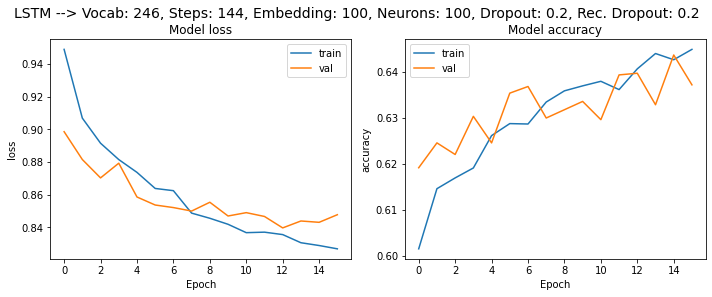

In [36]:
vocabulary_size = vocabulary_size
embedding_size = 100
time_steps = time_steps
num_neuron = 100
dropout = 0.2
recurrent_dropout = 0.2
EPOCHS = 20

# Build Model and Train
model = create_lstm_model(vocabulary_size=vocabulary_size, embedding_size=embedding_size, time_steps=time_steps, num_classes=3, num_neuron=num_neuron, dropout=dropout, recurrent_dropout=recurrent_dropout)
print(model.summary())
history = model.fit(X_train_encoded, y_train, validation_data=(X_test_encoded, y_test), epochs=EPOCHS, batch_size=256, callbacks=[es, checkpoint])
plot_metrics(history,
             metrics=['loss', 'accuracy'],
             title = f"LSTM --> Vocab: {vocabulary_size}, Steps: {time_steps}, Embedding: {embedding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")

In [37]:
# Save the model
model.save('unigram_model.h5')

# Emoji Vector

In [38]:
all_weights = history.model.get_weights()
embeddings = all_weights[0]
embeddings.shape

(246, 100)

In [39]:
emoji = None
for (char, num_occurance) in fdist.most_common():
  if num_occurance == 95:
    emoji = char
print(emoji) 

😂


In [40]:
emoji_index = word_index[emoji]
emoji_index

90

In [41]:
emoji_weight = embeddings[emoji_index]
emoji_weight

array([-2.39063445e-02, -7.19132423e-02,  9.97564718e-02,  6.45954954e-03,
       -6.18424490e-02, -5.70372045e-02,  1.43160895e-02, -2.02886388e-02,
        3.79882455e-02,  2.16219705e-02, -4.99909706e-02,  5.89939095e-02,
        3.48653411e-03,  1.95452735e-01,  2.32533664e-02, -1.52368433e-04,
       -9.25930664e-02, -6.69578016e-02,  4.11466062e-02, -5.49434498e-02,
       -2.67005060e-02, -1.23032779e-02, -8.24195892e-02, -7.84050375e-02,
       -1.67556312e-02, -9.89016965e-02,  1.02772210e-02,  7.94449076e-02,
       -7.53539652e-02,  5.46907447e-02, -7.47432094e-03, -5.75458677e-03,
        2.02195421e-02, -1.50325457e-02, -1.87606037e-01, -5.94125502e-02,
        3.26328799e-02,  1.87784433e-02, -6.90076947e-02,  7.49504194e-02,
       -5.80474176e-03,  6.67760596e-02, -1.77364379e-01,  1.30495220e-01,
        5.47937043e-02,  6.81054294e-02, -1.43899664e-01,  7.47839808e-02,
       -2.64429525e-02, -5.41716032e-02,  4.39281389e-02, -5.53959459e-02,
        5.99418022e-03,  

# Emoji Similarity

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embeddings)
similarities.shape

(246, 246)

In [43]:
emoji_similarities = similarities[emoji_index]
print(emoji_similarities.min())
print(emoji_similarities.max())

-0.67479426
1.0


In [44]:
emoji_similarities_sorted = emoji_similarities.copy()
emoji_similarities_sorted.sort()
print(emoji_similarities_sorted[-10:]) # 9 most similar (exclusing itself)

[0.55125856 0.5812193  0.60097533 0.603112   0.70746726 0.71561885
 0.7247434  0.7304565  0.7688519  1.        ]


In [45]:
# Last value would be comparison to itself, so we take the one before that
most_similar_similarity_value = emoji_similarities_sorted[-2]  
most_similar_similarity_value

0.7688519

In [46]:
indices = [i for i, value in enumerate(emoji_similarities) if value == most_similar_similarity_value]
indices

[86]

In [47]:
# Most Similar
reverse_word_index.get(indices[0])

'('